# Data Challenge - task 1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import random
%matplotlib inline

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Idea
- Find meaningful load time for freeletics (access app)
- Find values for X ( X users/day using new feature), Y-Z (loading time)
- Generate and visualize dummy data that simulate the scenario above over 24h. How did you model user traffic and SLFT? What parameters do you use? Why?
- Given dummy data, formulate hypothesis: "is the feature affecting SLFT in any way? Why?"
- Name, setup and explain the test that you would perform to test this hypothesis.


Let's generate dummy data. Our data is going to be like this (assume that loading time depends on total number of logs available):
UserId, Uses feature X, datetime, type of access (workout - social feed reading)

a) Meaningful numbers for X,Y,Z - go through Freeletics, test their API

b) Generate and visualize dummy data that models the scenario above over 24 hours. How did you model user traffic and SFLT? What parameters did you use? Why?

I assume that SFLT is dependent of:
1. user traffic (server takes longer to respond if there are more people online) and
2. Amount of information that needs to be retrieved (= number of workouts done)

So, I creata a sessions table for a 24h period, which basically contains access_logs of all users, every time they open the app. That means, that they can just retrieve their social feed (if they are instereted in their friends' workouts, for example) or they can make their own workout. I consider that everyone who completes a workout will check their social feed, just for simplicity.

I also use following hypothesis:
- Total number of active users N
- Workouts: I draw the datetime which people do workouts from 2 normal distributions, since I assume that, for a normal weekday, people are more likely to exercise on the morning (around 8 AM, standard deviation 1h) and around 8 PM (standard deviation 2h). So I come up with 10k people doing workouts within 24h (check numbers).
Also worth mentioning that I assume that 4N/7 people perform a workout in this specific day, since people normally exercise 4 times a week (so 4/7 probability per user * Number of users = 4*N/7)
- Social feeds (I): after completing workout, user immediately checks its social feed
- Social feeds (II): I assume that every user checks Freeletics once a day, at a random time between 6 AM and 10 PM.

Hypothesis regarding performance of social feed:
- I assume that user performing requests has an effect on the server for 5 minutes. That means that I will aggregate the number of online users in 5-minute buckets and, if there are more users online within those 5 minutes, the loading time should be longer than in a bucket containing less users. This is of course a simplification, but nevertheless it simplifies the approach.
- I also assume that the total number of workouts make a difference on the loading time. This implies that, if I check my social feed at 6 AM, it will take less to load than if I load it at 10 PM, since more workouts should load in my social feed. 

# Generate dummy data

In [2]:
# Generate random datetimes separeted by 5 minutes (google)
# UserId, Uses feature X, datetime, type of access (workout - social feed reading)

In [54]:
N = int(6.5*1e6) #total number of active users
np.random.seed(20)

In [55]:
# People checking their feeds at a random time of day
list_hour=[]
list_min=[]
max_hour=22
for i in range(N):
    list_hour.append(random.randrange(start=6,stop=max_hour,step=1))
    list_min.append(random.randrange(start=0,stop=55,step=5))

#store as times
list_checks=[]
for i,j in zip(list_hour,list_min):
    list_checks.append(datetime.time(i,j))  

UserIds = range(N)

checkIns = pd.DataFrame(UserIds,columns=['UserId'])
checkIns['time1'] = list_checks
checkIns['access_type'] = 'check_social_feed'
checkIns['uses_feature_X'] = 0

In [56]:
checkIns.head()

UserId     time1        access_type  uses_feature_X
0       0  06:25:00  check_social_feed               0
1       1  21:10:00  check_social_feed               0
2       2  08:00:00  check_social_feed               0
3       3  10:20:00  check_social_feed               0
4       4  21:40:00  check_social_feed               0

In [73]:
# 4N/7 People doing workouts (assume 20 minute workout) - assume coin toss to decide if user used feature or not.
# draw from Gaussian distribution 2*N/7 around 8AM, 2*n/7 around 8 PM

def coin_toss_workout_morning(row):
    if random.random() <= 0.25: #draw a random number between 0 and 1
        return 1
    else:
        return 0
def coin_toss_workout_evening(row):
    if random.random() <= 0.1: #draw a random number between 0 and 1
        return 1
    else:
        return 0

workout_morning = np.random.normal(loc=8,scale=2.,size=2*N/7)
workout_evening = np.random.normal(loc=20,scale=2.,size=2*N/7) #check for hours > 24

userIdsworkoutMorning = range(workout_morning.shape[0])
userIdsworkoutEvening = range(workout_morning.shape[0],workout_morning.shape[0]+workout_evening.shape[0])

df_workouts_morning = pd.DataFrame(userIdsworkoutMorning,columns=['UserId'])
df_workouts_evening = pd.DataFrame(userIdsworkoutEvening,columns=['UserId'])

df_workouts_morning['time1'] = workout_morning
df_workouts_morning['access_type'] = 'workout'
df_workouts_morning['uses_feature_X'] = df_workouts_morning.apply(coin_toss_workout_morning,axis=1)
df_workouts_evening['time1'] = workout_evening
df_workouts_evening['access_type'] = 'workout'
df_workouts_evening['uses_feature_X'] = df_workouts_evening.apply(coin_toss_workout_evening,axis=1)

#merge 2 data frames
workouts = df_workouts_morning.append(df_workouts_evening)
workouts.time1 = pd.to_numeric(workouts.time1.apply(lambda x: x%24)) #correct for times after 12 PM
workouts.time1 = workouts.time1.apply(lambda x: datetime.datetime(2017,3,28,int(x),int(x%(max(int(x),1))*60)))

In [74]:
print workouts.shape
workouts.head()

(3714284, 4)


UserId               time1 access_type  uses_feature_X
0       0 2017-03-28 08:11:00     workout               0
1       1 2017-03-28 09:35:00     workout               1
2       2 2017-03-28 09:21:00     workout               0
3       3 2017-03-28 09:17:00     workout               0
4       4 2017-03-28 07:43:00     workout               0

In [75]:
# People directly checking feed after workout
check_feed_after_workout = workouts.copy()
check_feed_after_workout['uses_feature_X'] = 0
check_feed_after_workout['access_type']='check_social_feed'
check_feed_after_workout['time1'] =  check_feed_after_workout['time1'].apply(lambda x: x + datetime.timedelta(minutes=20))#20 min afterwards

In [76]:
check_feed_after_workout.head()

UserId               time1        access_type  uses_feature_X
0       0 2017-03-28 08:31:00  check_social_feed               0
1       1 2017-03-28 09:55:00  check_social_feed               0
2       2 2017-03-28 09:41:00  check_social_feed               0
3       3 2017-03-28 09:37:00  check_social_feed               0
4       4 2017-03-28 08:03:00  check_social_feed               0

In [77]:
# Concatenate data frames - check sizes
print workouts.shape
print check_feed_after_workout.shape
print checkIns.shape
print checkIns.append(workouts,ignore_index=True).append(check_feed_after_workout,ignore_index=True).shape

(3714284, 4)
(3714284, 4)
(6500000, 4)
(13928568, 4)


In [78]:
#store events (workouts, check social feeds in unique data frame)
eventLog = checkIns.append(workouts,ignore_index=True).append(check_feed_after_workout,ignore_index=True)


In [79]:
eventLog.head()

UserId     time1        access_type  uses_feature_X
0       0  06:25:00  check_social_feed               0
1       1  21:10:00  check_social_feed               0
2       2  08:00:00  check_social_feed               0
3       3  10:20:00  check_social_feed               0
4       4  21:40:00  check_social_feed               0

In [81]:
eventLog['time_for_index'] = eventLog.time1.apply(lambda x: datetime.time((x.hour-1)%24,x.minute,x.second))

In [82]:
eventLog.head()

UserId     time1        access_type  uses_feature_X time_for_index
0       0  06:25:00  check_social_feed               0       05:25:00
1       1  21:10:00  check_social_feed               0       20:10:00
2       2  08:00:00  check_social_feed               0       07:00:00
3       3  10:20:00  check_social_feed               0       09:20:00
4       4  21:40:00  check_social_feed               0       20:40:00

In [83]:
#1 - number of online_users (user_traffic)
# df.groupby(pd.TimeGrouper('5Min'))
#eventLog.set_index('time1',inplace=True)
eventLog.index = eventLog.time_for_index 
eventLog.index = pd.to_datetime([datetime.datetime.fromtimestamp(time.mktime((2017,3,28,item.hour,item.minute,item.second,0,0,0))) 
                           for item in eventLog.index])

#eventLog.index = eventLog.index.apply(lambda x: x - datetime.timedelta(hours=1))

In [84]:
eventLog.head()

UserId     time1        access_type  uses_feature_X  \
2017-03-28 06:25:00       0  06:25:00  check_social_feed               0   
2017-03-28 21:10:00       1  21:10:00  check_social_feed               0   
2017-03-28 08:00:00       2  08:00:00  check_social_feed               0   
2017-03-28 10:20:00       3  10:20:00  check_social_feed               0   
2017-03-28 21:40:00       4  21:40:00  check_social_feed               0   

                    time_for_index  
2017-03-28 06:25:00       05:25:00  
2017-03-28 21:10:00       20:10:00  
2017-03-28 08:00:00       07:00:00  
2017-03-28 10:20:00       09:20:00  
2017-03-28 21:40:00       20:40:00

In [85]:
online_users = eventLog[eventLog.access_type=='check_social_feed'].groupby(by=pd.TimeGrouper('5Min'),as_index=True).agg({
                                                                        'UserId':pd.Series.nunique})

In [86]:
online_users.head()

UserId
2017-03-28 01:00:00    1954
2017-03-28 01:05:00    1797
2017-03-28 01:10:00    1628
2017-03-28 01:15:00    1494
2017-03-28 01:20:00    1439

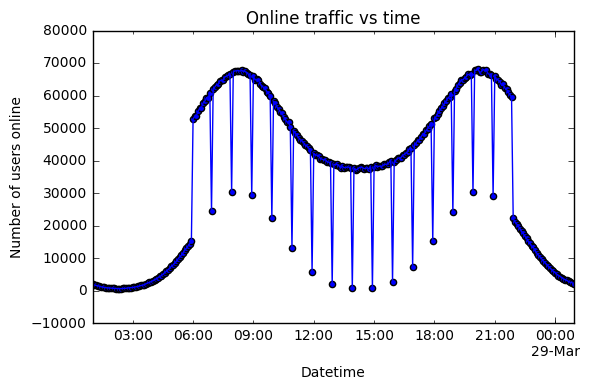

In [87]:
plt.subplot(111)
online_users['UserId'].plot(kind='line')
plt.scatter(online_users.index,online_users.UserId)
plt.title('Online traffic vs time')
plt.xlabel('Datetime')
plt.ylabel('Number of users online')
plt.tight_layout()
plt.show()


# Total number of workouts

In [88]:
eventLog['flag_workout'] = eventLog.access_type.apply(lambda x: 1 if x=='workout' else 0)
#eventLog['cum_num_workouts'] = eventLog.flag_workout.cumsum()

In [89]:
eventLog[eventLog.access_type=='workout'].head()

UserId                time1 access_type  uses_feature_X  \
2017-03-28 08:11:00       0  2017-03-28 08:11:00     workout               0   
2017-03-28 09:35:00       1  2017-03-28 09:35:00     workout               1   
2017-03-28 09:21:00       2  2017-03-28 09:21:00     workout               0   
2017-03-28 09:17:00       3  2017-03-28 09:17:00     workout               0   
2017-03-28 07:43:00       4  2017-03-28 07:43:00     workout               0   

                    time_for_index  flag_workout  
2017-03-28 08:11:00       07:11:00             1  
2017-03-28 09:35:00       08:35:00             1  
2017-03-28 09:21:00       08:21:00             1  
2017-03-28 09:17:00       08:17:00             1  
2017-03-28 07:43:00       06:43:00             1

In [90]:
eventLogsortedIndex=eventLog.sort_index()
eventLogsortedIndex['cumulative_workouts']=eventLogsortedIndex.groupby(by=pd.TimeGrouper('5Min'),as_index=False)['flag_workout'].cumsum()
eventLogsortedIndex['cumulative_workouts_X'] = eventLogsortedIndex.groupby(by=pd.TimeGrouper('5Min'),as_index=False)['uses_feature_X'].cumsum()

In [98]:
workouts_logs = eventLogsortedIndex.groupby(by=pd.TimeGrouper('5Min'),as_index=True).agg({'cumulative_workouts':sum,
                                                                'cumulative_workouts_X':sum})
workouts_logs_sum = workouts_logs.cumsum()

In [101]:
workouts_logs_sum.head()

cumulative_workouts_X  cumulative_workouts
2017-03-28 01:00:00                 270252              2449075
2017-03-28 01:05:00                 471610              4255420
2017-03-28 01:10:00                 644289              5857880
2017-03-28 01:15:00                 826985              7130252
2017-03-28 01:20:00                 961981              8257817

- [Y,Z] range of loading of social feed - should be around few seconds, so I choose Y=1s and Z=2s for simplicity.
- For the calculation of X users/day that used feature X (the new feature), I make the following assumptions:
    
    1. People that exercise on the morning (around the 8 AM peak) have a 25% chance of trying it. 
    2. People that exercise on the evening have a 10% chance of adopting the new feature.
    Since the logging feature enables people who train offline to upload their content online, I assume that less people will try that on the evening, since it's more likely that people how train late are less likely to be doing that in a place without internet than someone who trains early (jogs, or go to a park exercise).
- Calculate number N of people completing a workout at a given day: I read online that Freeletics has 11 MM registered users (total users). Using data from Facebook (65%) and Twitter (45%) (https://www.quora.com/What-is-a-good-ratio-of-daily-active-users-to-total-users-for-an-up-and-coming-iOS-social-network-app), I assumed that Freeletics has 50% of active users. That would give us 6.5 MM active users (use platform everyday). From that number N, I assumed that the probability that a person would exercise at this day to be 4/7, assuming that a normal client exercises 4x per week.

So, I have 2 contributions for number X of expected users:
- Half is working out on the morning, so chance to use logging is 10%. That gives 6.5MM x 2/7 (prob to exercise) x 0.1 (prob to use logging feature) = 185k workouts with feature
- Half is working out on the evening, so chance to use logging is 25%. That gives 6.5MM x 2/7 (prob to exercise) x 0.25 (prob to use logging feature) = 464k workouts with feature
So total gives us X which is approx. 649,000 people using this feature/day.


# Model user traffic and Loading time (SLFT)

Let's start with the traffic, which is a parameter for the loading time.
I model the traffic as being the total number of users online (within this 5min bucket) that makes a request to the social feed. 
We have 2 main contributions to those requests: first, people who randomly check their social feeds (I assumed (active users) a random distribution of people (N people = active users) around 6AM and 10PM check their feeds). Second, I assumed that people who just finished their workout check their social feed (as I do).

So the final distribution of user traffic can be seen on the graph below

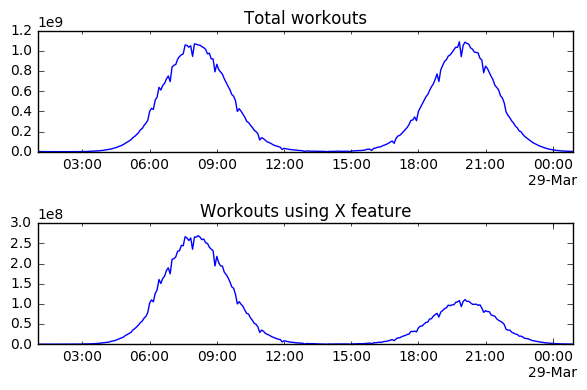

In [126]:
plt.subplot(211)
plt.title('Total workouts')
workouts_logs.cumulative_workouts.plot(kind='line')
plt.subplot(212)
plt.title('Workouts using X feature')
workouts_logs.cumulative_workouts_X.plot(kind='line')
plt.tight_layout()
plt.show()

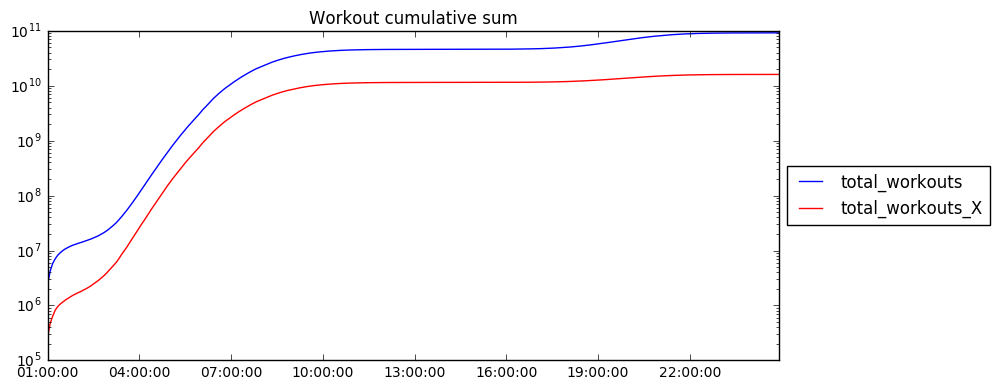

In [124]:
# Cumulative sum
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plt.title('Workout cumulative sum')
ax.semilogy(workouts_logs_sum.index,(workouts_logs_sum.cumulative_workouts),'b',label='total_workouts')
plt.semilogy(workouts_logs_sum.index,(workouts_logs_sum.cumulative_workouts_X),'r',label='total_workouts_X')
#ax.semilogy(np.log10(x), y)
plt.tight_layout()
box = ax.get_position()

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [135]:
# combine 2 data frames (workouts, online users) to assess loading time
loading_times = pd.merge(workouts_logs_sum,online_users,left_index=True,right_index=True)

In [222]:
# model for loading time
normalization = 1./(5e5)
coeff_workouts = 5.e-6
coeff_num_users = 7.
loading_times['SFLT_fit1'] = normalization*(coeff_workouts*loading_times.cumulative_workouts +coeff_num_users*loading_times.UserId)
######## 2nd option
coeff_workouts2 = 5.e-6
coeff_num_users2 = 1.
loading_times['SFLT_fit2'] = normalization*(coeff_workouts2*loading_times.cumulative_workouts +coeff_num_users2*loading_times.UserId)

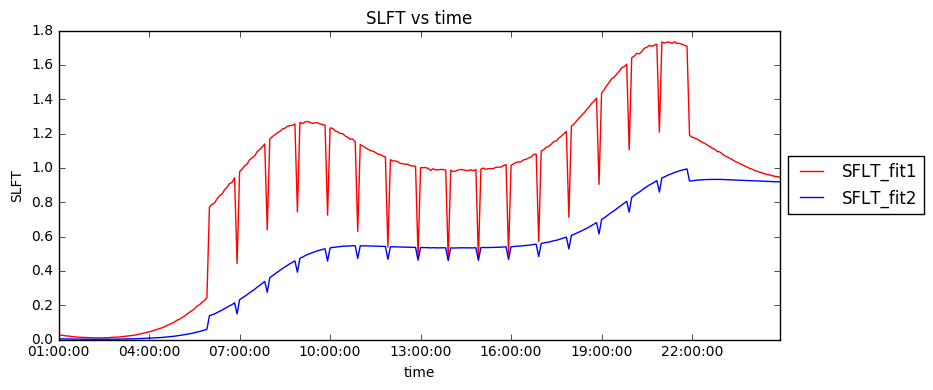

In [226]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plt.plot(loading_times.index,loading_times.SFLT_fit1,'r')
plt.plot(loading_times.index,loading_times.SFLT_fit2,'b')
plt.title('SLFT vs time')
plt.ylabel('SLFT')
plt.xlabel('time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In the above figure of the SLFT, it can seen that, according to the parameters chosen to the fit, i.e. depending on the linear coefficients that are chosen for modelling the dependence of the SFLT with respect to the user traffic and the total number of workouts, the loading time can get close to 2s, or rather stay at bareable levels close to 1s.

So, for this specific dummy data, the feature X is not interfering on the loading times significantly, since it is still inside the specified ranges [1s-2s]. Due to time constraints, I will finish my analysis here. Nevertheless, if I had additional time to complete the task, the hypothesis I would like to test is "does feature X affect the number of total workouts and/or the number of online users by a significant amount"?
For completeness, my suggestion would be to roll back the feaure, since according to the SFLT graph the ranges stayed within the specified range. I cannot provide errors or degree of confidence since my coefficients were arbitrary, but for real data such accuracy calculation would be straightforward.

# Conclusions

- It would be interesting to have real data containing which kind of incentives Freeletics gives to people and how effective they are (eg push notifications, Coach sends instructions to user, etc)
- Also important to notice that I did not include number of followers per user. That is also relevant for the analysis, since the more people I follow, the longer will it take to load my feed. That was left out of the analysis due to time constraints, but it would be very interesting to have more time to do it with real data.